In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader

**IMPORTING** **DATASET**

In [17]:
import re

image_folder = r"/content/drive/MyDrive/Colab Notebooks/images"

def extract_number(filename):
    return int(re.search(r'\d+', filename).group())

image_files = sorted(
    [f for f in os.listdir(image_folder)
     if f.lower()],
    key=extract_number
)

print("First 10 images:")
for img in image_files[:10]:
    print(img)

print("\nTotal images:", len(image_files))

First 10 images:
image_0.jpg
image_1.jpg
image_2.jpg
image_3.jpg
image_4.jpg
image_5.jpg
image_6.jpg
image_7.jpg
image_8.jpg
image_9.jpg

Total images: 972


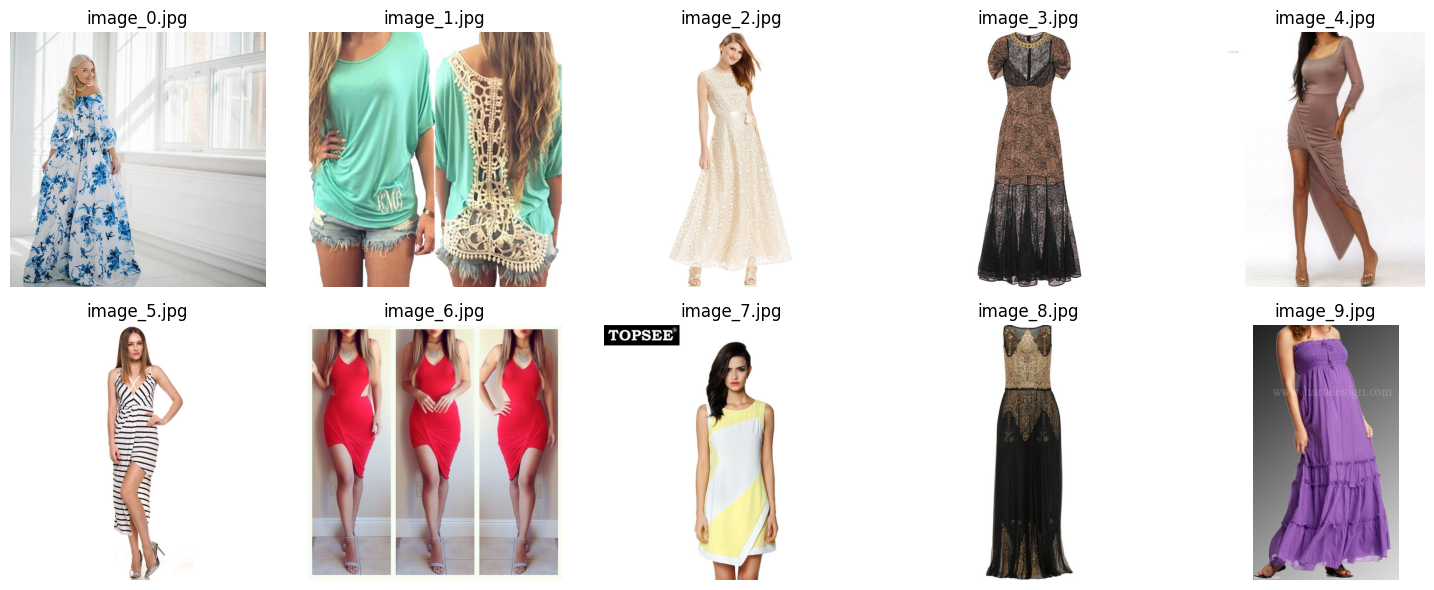

In [18]:
plt.figure(figsize=(15, 6))

for i in range(10):
    img_path = os.path.join(image_folder, image_files[i])
    image = Image.open(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(image_files[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
label_file = "labels.txt"

label_data = []

with open(label_file, "r") as f:
    lines = f.readlines()

for line in lines:
    line = line.strip()

    if len(line) == 0:
        continue

    parts = line.split()

    image_name = parts[0]
    attrs = parts[1:]

    labels = []
    mask = []

    for attr in attrs:
        if attr == "NA":
            labels.append(0)
            mask.append(0)
        else:
            labels.append(int(attr))
            mask.append(1)

    label_data.append({
        "image_name": image_name,
        "labels": labels,
        "mask": mask
    })

# Print first 5 entries to verify
for item in label_data[:5]:
    print(item)

{'image_name': 'image_0.jpg', 'labels': [1, 0, 0, 1], 'mask': [1, 0, 1, 1]}
{'image_name': 'image_1.jpg', 'labels': [0, 0, 0, 0], 'mask': [0, 1, 1, 1]}
{'image_name': 'image_2.jpg', 'labels': [1, 1, 0, 0], 'mask': [1, 1, 1, 1]}
{'image_name': 'image_3.jpg', 'labels': [1, 1, 0, 0], 'mask': [1, 1, 1, 1]}
{'image_name': 'image_4.jpg', 'labels': [1, 1, 0, 0], 'mask': [1, 1, 1, 1]}


**Preprocessing according to the Model being used**

In [20]:
# training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [21]:
# validation
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [22]:
torch.manual_seed(42)

all_images_tensor = []
all_labels_tensor = []
all_masks_tensor = []

for item in label_data:
    img_name = item["image_name"]
    img_path = os.path.join(image_folder, img_name)
    try:
        image = Image.open(img_path).convert("RGB")

        transformed_image = train_transform(image)
        all_images_tensor.append(transformed_image)

        labels = torch.tensor(item["labels"], dtype=torch.float32)
        mask = torch.tensor(item["mask"], dtype=torch.float32)

        all_labels_tensor.append(labels)
        all_masks_tensor.append(mask)
    except FileNotFoundError:
        print(f"Image file not found: {img_path}. Skipping this image.")
        continue

if not all_images_tensor:
    print("Cannot proceed with data splitting.")
else:
    images = torch.stack(all_images_tensor)
    labels = torch.stack(all_labels_tensor)
    masks = torch.stack(all_masks_tensor)

    N = images.shape[0]

    train_size = int(0.8 * N)
    val_size = N - train_size

    indices = torch.randperm(N)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_images = images[train_indices]
    train_labels = labels[train_indices]
    train_masks  = masks[train_indices]

    val_images = images[val_indices]
    val_labels = labels[val_indices]
    val_masks  = masks[val_indices]

    print("Train size:", train_images.shape[0])
    print("Validation size:", val_images.shape[0])

Image file not found: /content/drive/MyDrive/Colab Notebooks/images/image_489.jpg. Skipping this image.
Image file not found: /content/drive/MyDrive/Colab Notebooks/images/image_624.jpg. Skipping this image.
Image file not found: /content/drive/MyDrive/Colab Notebooks/images/image_875.jpg. Skipping this image.
Train size: 777
Validation size: 195


1. Training code which takes in the images and labels as input and produces a   
   deep -model file containing weights.

  MODEL training - **Pretrained EfficientNet-B0**

In [23]:
from torchvision.models import EfficientNet_B0_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 4)
print(f"Classifier replaced with a new linear layer for 4 output features. Original in_features: {num_features}")

for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)
print(f"Model moved to {device}.")

criterion = nn.BCEWithLogitsLoss(reduction='none')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Classifier replaced with a new linear layer for 4 output features. Original in_features: 1280
Model moved to cpu.


In [24]:
num_epochs = 10
batch_size = 32

training_losses = []

for epoch in range(num_epochs):
    model.train()

    epoch_loss = 0
    num_batches = 0

    perm = torch.randperm(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]
    train_masks  = train_masks[perm]

    for i in range(0, train_images.shape[0], batch_size):

        images = train_images[i:i+batch_size].to(device)
        labels = train_labels[i:i+batch_size].to(device)
        masks  = train_masks[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss * masks
        loss = loss.sum() / (masks.sum() + 1e-8)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    training_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Training Loss: {avg_loss:.4f}")

Epoch [1/10]  Training Loss: 0.5392
Epoch [2/10]  Training Loss: 0.4776
Epoch [3/10]  Training Loss: 0.4571
Epoch [4/10]  Training Loss: 0.4595
Epoch [5/10]  Training Loss: 0.4459
Epoch [6/10]  Training Loss: 0.4393
Epoch [7/10]  Training Loss: 0.4275
Epoch [8/10]  Training Loss: 0.4189
Epoch [9/10]  Training Loss: 0.4206
Epoch [10/10]  Training Loss: 0.4162


**weight calculation and fine tuning**

In [25]:
positive_counts = (train_labels * train_masks).sum(dim=0)

total_known = train_masks.sum(dim=0)

negative_counts = total_known - positive_counts

pos_weight = negative_counts / (positive_counts + 1e-8)

print("Positive counts:", positive_counts)
print("Negative counts:", negative_counts)
print("pos_weight:", pos_weight)

Positive counts: tensor([625., 576., 372.,  59.])
Negative counts: tensor([ 90., 135., 335., 644.])
pos_weight: tensor([ 0.1440,  0.2344,  0.9005, 10.9153])


In [26]:
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss(
    reduction='none',
    pos_weight=pos_weight.to(device)
)

In [27]:
model.eval()

val_loss_total = 0
val_batches = 0

with torch.no_grad():
    for i in range(0, val_images.shape[0], batch_size):

        images = val_images[i:i+batch_size].to(device)
        labels = val_labels[i:i+batch_size].to(device)
        masks  = val_masks[i:i+batch_size].to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss = loss * masks
        loss = loss.sum() / (masks.sum() + 1e-8)

        val_loss_total += loss.item()
        val_batches += 1

avg_val_loss = val_loss_total / val_batches

print("Validation Loss:", avg_val_loss)

Validation Loss: 0.6499201144490924


In [28]:
for param in model.features.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

print("Backbone layers unfrozen. Optimizer reinitialized.")

Backbone layers unfrozen. Optimizer reinitialized.


In [29]:
num_epochs_finetune = 5

print(f"Starting fine-tuning for {num_epochs_finetune} epochs...")

for epoch in range(num_epochs_finetune):
    model.train()

    epoch_loss = 0
    num_batches = 0

    perm = torch.randperm(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]
    train_masks  = train_masks[perm]

    for i in range(0, train_images.shape[0], batch_size):

        images = train_images[i:i+batch_size].to(device)
        labels = train_labels[i:i+batch_size].to(device)
        masks  = train_masks[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss * masks
        loss = loss.sum() / (masks.sum() + 1e-8)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    training_losses.append(avg_loss)

    print(f"Fine-tune Epoch [{epoch+1}/{num_epochs_finetune}] Training Loss: {avg_loss:.4f}")

Starting fine-tuning for 5 epochs...
Fine-tune Epoch [1/5] Training Loss: 0.7476
Fine-tune Epoch [2/5] Training Loss: 0.6943
Fine-tune Epoch [3/5] Training Loss: 0.6225
Fine-tune Epoch [4/5] Training Loss: 0.6135
Fine-tune Epoch [5/5] Training Loss: 0.5858


In [30]:
model.eval()

val_loss_total = 0
val_batches = 0

with torch.no_grad():
    for i in range(0, val_images.shape[0], batch_size):

        images = val_images[i:i+batch_size].to(device)
        labels = val_labels[i:i+batch_size].to(device)
        masks  = val_masks[i:i+batch_size].to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss = loss * masks
        loss = loss.sum() / (masks.sum() + 1e-8)

        val_loss_total += loss.item()
        val_batches += 1

avg_val_loss = val_loss_total / val_batches

print("Fine-tune Validation Loss:", avg_val_loss)

Fine-tune Validation Loss: 0.5905024196420398


2. **Loss curve plot with loss in y axis and iteration number in x axis** for training images. Ylabel and Xlabel.

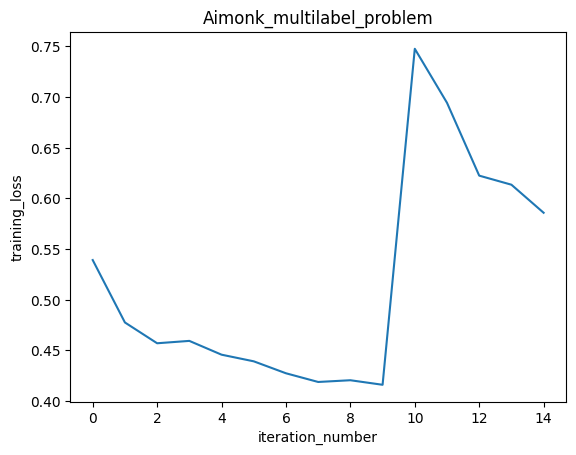

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_losses)
plt.xlabel("iteration_number")
plt.ylabel("training_loss")
plt.title("Aimonk_multilabel_problem")
plt.show()

3. Inference code which takes in an image as input and prints the list of attributes present in that image.

In [32]:
def predict_attributes(image_file_path, model, transform, attribute_names, device, threshold=0.5):
    try:
        image = Image.open(image_file_path).convert("RGB")
    except FileNotFoundError:
        return [f"Error: Image file not found at {image_file_path}"]
    except Exception as e:
        return [f"Error loading image: {e}"]

    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_image)
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > threshold).int().squeeze(0).cpu().numpy()

    results = []
    for i, pred in enumerate(predictions):
        status = "Present" if pred == 1 else "Not Present"
        results.append(f"{attribute_names[i]}: {status}")

    return results


### Upload Image and Get Predictions

In [33]:
attribute_names = ['attr_1', 'attr_2', 'attr_3', 'attr_4']

Attempting inference for: /content/drive/MyDrive/Colab Notebooks/images/image_8.jpg


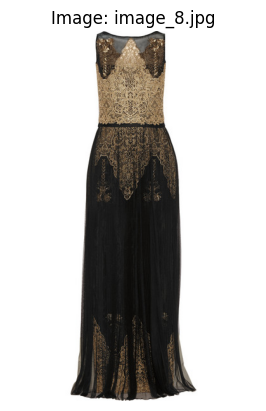


Predictions for /content/drive/MyDrive/Colab Notebooks/images/image_8.jpg:
attr_1: Present
attr_2: Present
attr_3: Not Present
attr_4: Not Present


In [39]:
image_file_path = '/content/drive/MyDrive/Colab Notebooks/images/image_8.jpg'

print(f"Attempting inference for: {image_file_path}")

# Open and display the image
try:
    image = Image.open(image_file_path).convert("RGB")
    plt.imshow(image)
    plt.title(f"Image: {os.path.basename(image_file_path)}")
    plt.axis("off")
    plt.show()
except FileNotFoundError:
    print(f"Error: Image file not found at {image_file_path}. Cannot display image.")
except Exception as e:
    print(f"Error displaying image: {e}")

prediction_results = predict_attributes(
    image_file_path=image_file_path,
    model=model,
    transform=val_transform,
    attribute_names=attribute_names,
    device=device
)

print(f"\nPredictions for {image_file_path}:")
for result in prediction_results:
    print(result)